## Instructions

- Follow the installation instructions in the readme file
- Answer the questions in this notebook
- Once your work is finished: restart the kernel, run all cells in order and check that the outputs are correct.
- Send your completed notebook to `remy.degenne@inria.fr` with email title `SL_TP3_NAME1_NAME2` (or `SL_TP3_NAME` if you work alone).

**Deadline: January 30, 11:59 AM CET**.

If you don't want to use a local installation, you can try Google Colab:

<a target="_blank" href="https://colab.research.google.com/github/RemyDegenne/remydegenne.github.io/blob/master/docs/SL_2025/Bandit.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

In [1]:
# This cell is setting up google colab. Ignore it if you work locally.
if 'google.colab' in str(get_ipython()):
    print("Installing packages, please wait a few moments. Restart the runtime after the installation.")
    # install rlberry library
    !pip install scipy rlberry

In [2]:
import numpy as np
import random as rd
import scipy.stats as st
import gymnasium as gym
from matplotlib import pyplot as plt
import time

rng = np.random.default_rng(45161641614384786754156467846542343184353443258463569)

# Bandits

Bandits can be seen as RL with only one state. A bandit environment with $K$ actions (or arms) is parametrized by $K$ distributions $\nu_1, \ldots, \nu_K$ with finite means $\mu_1, \ldots, \mu_K$. At each time $t \in \mathbb{N}$, an agent
- chooses an arm $A_t \in \{1, \ldots, K\}$ (possibly based on previous observations)
- gets a reward $X_{A_t, t} \sim \nu_{A_t}$ samples from the distribution of arm $A_t$

In the regret minimization setting, the agent seeks to minimize its expected regret at some horizon $T$,
$$R_T = T \max_k \mu_k - \sum_{t = 1}^T \mu_{A_t} \: .$$

More precisely, we will evaluate agents/algorithms based on their expected regret $\mathbb{E}[R_T]$.

**Implement a function that computes the regret of a sequence of actions**

The result will be an array of length T = len(actions) containing the values of $R_t$ for all $t < T$.

In [3]:
def regret(means, actions):
    """
    Compute the regret of a sequence of actions on a bandit problem with given means

    means: numpy.ndarray; vector of means of the arm distributions, of size K
    actions: list of int in 0, ..., K-1; sequence of actions

    Returns: numpy.ndarray; regret of the sequence of actions at each time t <= len(actions)
    """
    # Identify the best possible mean (optimal arm)
    mu_max = np.max(means)
    
    # Retrieve the true mean of the arm chosen at each step
    chosen_means = np.array([means[a] for a in actions])
    
    # Calculate instantaneous regret
    instant_regret = mu_max - chosen_means
    
    # Return the cumulative sum (R_t)
    return np.cumsum(instant_regret)

### Bandit environments

We will test our bandits algorithms on Gaussian distributions with variance 1 and on Bernoulli distributions.

In [4]:
class Bandit:
    def __init__(self, distrib):
        self.distributions = distrib
        self.means = [dist.mean() for dist in distrib]

    def sample(self, arm, n=1):
        # return n samples from one arm distribution, as a numpy array
        return self.distributions[arm].rvs(n)

class GaussianBandit(Bandit):
    def __init__(self, means):
        distrib = [st.norm(loc=m) for m in means]
        super().__init__(distrib)

class BernoulliBandit(Bandit):
    def __init__(self, means):
        distrib = [st.bernoulli(p=m) for m in means]
        super().__init__(distrib)

Example:

In [5]:
mu = np.array([0.3, 0.5, 0.25])
K = len(mu)
B1 = GaussianBandit(mu)
B2 = BernoulliBandit(mu)
print(B1.sample(2, 10))  # 10 samples of arm 2 in bandit B1
print(B1.means[2])  # mean of arm 2 in bandit B1
print(B2.sample(2))  # 1 sample of arm 2 in bandit B2
print(B2.means[2])  # mean of arm 2 in bandit B2

[ 1.77283388  0.68055028  0.2753157  -0.29986083  1.6702501   1.06359641
  1.57178209 -1.09008205  1.04217022 -0.17589656]
0.25
[1]
0.25


# Failure of Follow-The-Leader

The Follow-The-Leader algorithm (FTL) for bandits pulls each arm once and then pulls at each time the arm with highest empirical mean. That is, it pulls
$$
A_t = \arg\max_a \hat{\mu}_{t,a}
$$
where $\hat{\mu}_{t,a} = \frac{1}{N_{t,a}}\sum_{s=1}^{t-1} X_{A_s, s} \mathbb{I}\{A_s = a\}$ and $N_{t,a} = \sum_{s=1}^{t-1} \mathbb{I}\{A_s = a\}$.

**What is in general the dependence in the horizon $T$ of the expected regret of FTL?**

---

The dependence of FTL regret on the horizon $T$ is Linear, i.e., $O(T)$.

**Reason:** FTL is a pure exploitation algorithm. If the first few samples are unlucky for the optimal arm and lucky for a suboptimal arm, FTL will lock onto the suboptimal arm and never explore the optimal one again.

---

**Implement the Follow-The-Leader algorithm**

In general, a bandit algorithm uses the whole sequence of past interactions to decide which arm should be pulled next. However, all algorithm we will implement in this notebook are functions of the number of past pulls of the arms and their empirical means, as well as the current time.

In [6]:
def FTL(emp_means, nb_pulls, t):
    """
    Follow-The-Leader arm selection

    emp_means: numpy.ndarray; vector of empirical means of the arms
    nb_pulls: numpy.ndarray; number of times each arm was chosen previously
    t: int; current time

    Returns: int; arm selected by FTL
    """
    # FTL simply chooses the arm with the highest empirical mean.
    # np.argmax returns the first index in case of ties.
    return np.argmax(emp_means)

**Plot the mean regret of FTL on a Gaussian bandit with 4 arms with means [0.3, 0.5, 0.25, 0.1] as a function of $t$ up to $T = 2000$, averaged over 30 experiments.**

In [8]:
T = 2000
N = 30

In [11]:
def run_experiment_detailed(bandit, algorithm, T, n_experiments=30):
    """
    Runs the experiment and returns the full matrix of regrets.
    Returns: numpy array of shape (n_experiments, T)
    """
    K = len(bandit.means)
    all_regrets = []
    
    for _ in range(n_experiments):
        actions = []
        emp_means = np.zeros(K)
        nb_pulls = np.zeros(K)
        
        for t in range(1, T + 1):
            action = algorithm(emp_means, nb_pulls, t)
            reward = bandit.sample(action)[0]
            
            actions.append(action)
            nb_pulls[action] += 1
            emp_means[action] += (reward - emp_means[action]) / nb_pulls[action]
            
        # Store the regret sequence for this specific run
        all_regrets.append(regret(bandit.means, actions))
        
    return np.array(all_regrets)

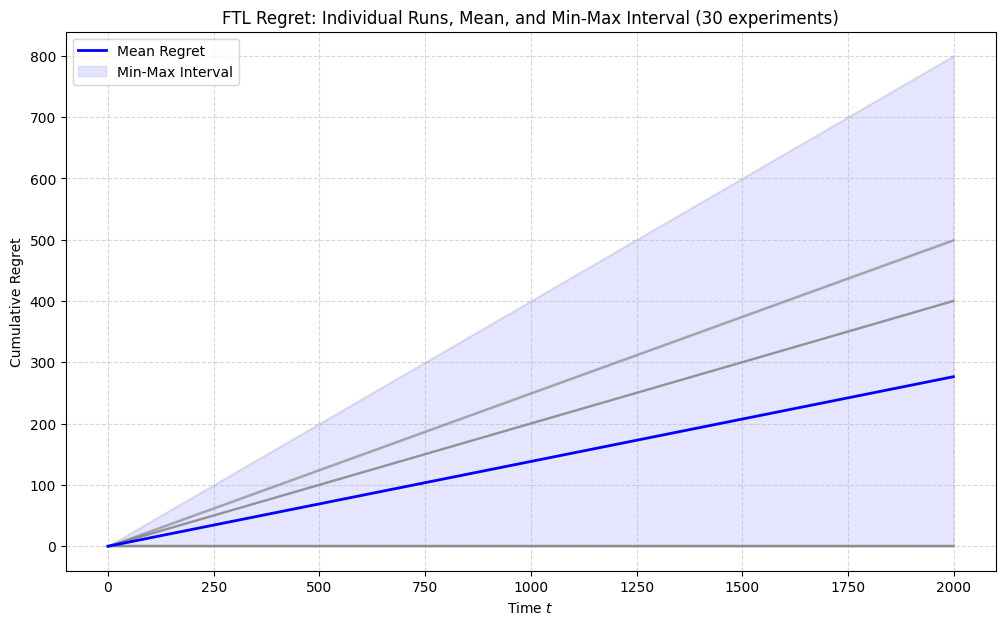

In [12]:
# 1. Setup
means = [0.3, 0.5, 0.25, 0.1]
bandit = GaussianBandit(means)
# 2. Run detailed experiments
# We get a matrix of shape (30, 2000)
regret_data = run_experiment_detailed(bandit, FTL, T, N)

# 3. Calculate Statistics
mean_curve = np.mean(regret_data, axis=0)
min_curve = np.min(regret_data, axis=0)
max_curve = np.max(regret_data, axis=0)

# 4. Plot
plt.figure(figsize=(12, 7))

# Plot all individual runs (light transparency)
# We transpose (.T) so that each column is plotted as a separate line
plt.plot(regret_data.T, color='gray', alpha=0.15)

# Plot the Mean
plt.plot(mean_curve, color='blue', linewidth=2, label='Mean Regret')

# Plot the Interval (Min to Max)
plt.fill_between(range(T), min_curve, max_curve, color='blue', alpha=0.1, label='Min-Max Interval')

# Labels and Styling
plt.xlabel('Time $t$')
plt.ylabel('Cumulative Regret')
plt.title(f'FTL Regret: Individual Runs, Mean, and Min-Max Interval ({N} experiments)')
plt.legend(loc='upper left')
plt.grid(True, linestyle='--', alpha=0.5)

plt.show()

**Look at several individual runs of FTL (in particular look at the sequence of actions). How can we explain the bad expected regret of FTL?**


---

### Explanation of FTL's Failure

The bad expected regret of Follow-The-Leader (FTL) is caused by its **complete lack of exploration**.

1. **The Locking Effect:**
FTL always chooses the arm with the highest *current* empirical mean. If, purely by bad luck (noise), the optimal arm yields a low reward the first time it is pulled, its empirical mean will drop below that of a suboptimal arm.

2. **No Correction Mechanism:**
Once the optimal arm is underestimated, FTL switches to a suboptimal arm. If that suboptimal arm continues to provide rewards that are "decent" (higher than the underestimated optimal arm), FTL will **never pull the optimal arm again**. It never collects new data to correct its false belief about the optimal arm.

3. **Sequence of Actions:**
Consequently, the sequence of actions typically looks like `[0, 1, 2, 3, 1, 1, 1, 1, 1, ...]`. It quickly "locks" onto a single arm . If  is suboptimal, the agent accumulates a constant regret at every time step , leading to a **linear expected regret**  (represented by the straight lines in the graph).

---

# $\varepsilon$-greedy

In order to obtain sub-linear regret, an algorithm should balance *exploration* and *exploitation*. The $\varepsilon$-greedy algorithm selects with probability $\varepsilon$ an arm uniformly at random (exploration) and with probability $1 - \varepsilon$ it chooses the empirical best arm like FTL.

**Implement $\varepsilon$-greedy for a decreasing $\varepsilon_t = c/t$, where $c$ is a parameter and $t$ is the current time.**

In [13]:
def eps_greedy(emp_means, nb_pulls, t):
    """
    eps-greedy arm selection

    emp_means: numpy.ndarray; vector of empirical means of the arms
    nb_pulls: numpy.ndarray; number of times each arm was chosen previously
    t: int; current time

    Returns: int; arm selected by eps-greedy
    """
    K = len(emp_means)
    
    # Parameter c (usually between 1 and 5 depending on the gap)
    c = 1 
    
    # Calculate decaying epsilon
    # We use min(1, ...) to ensure it's a valid probability at t=1
    epsilon = min(1, c / t)
    
    # Exploration: random arm
    if np.random.random() < epsilon:
        return np.random.randint(K)
    
    # Exploitation: best current arm (same as FTL)
    else:
        return np.argmax(emp_means)

# UCB

The UCB algorithm is optimistic: it selects the arm with highest upper confidence bound. Using concentration of measure arguments, we can construct confidence intervals on the means of each arm, such that the true mean belongs to the interval with large enough probability. UCB then selects the arm with highest upper bound for the confidence interval.

The algorithm starts by pulling all arms: $A_t = t$ for $t \le K$. Then, using a confidence interval obtained from a 1-sub-Gaussian assumption, UCB selects

$$A_t = \arg\max_a \hat{\mu}_{t,a} + \sqrt{\frac{2 \log t}{N_{t,a}}} \: .$$



**Implement the UCB algorithm**

In [14]:
def UCB(emp_means, nb_pulls, t):
    """
    UCB arm selection

    emp_means: numpy.ndarray; vector of empirical means of the arms
    nb_pulls: numpy.ndarray; number of times each arm was chosen previously
    t: int; current time

    Returns: int; arm selected by UCB
    """
    # The instructions say: "The algorithm starts by pulling all arms: A_t = t for t <= K"
    # We check if any arm has 0 pulls.
    for k in range(len(nb_pulls)):
        if nb_pulls[k] == 0:
            return k
            
    # Calculate the UCB index
    # Formula: mean + sqrt(2 * log(t) / N_a)
    confidence_bound = np.sqrt(2 * np.log(t) / nb_pulls)
    ucb_values = emp_means + confidence_bound
    
    return np.argmax(ucb_values)

**Plot the mean regret of FTL, $\varepsilon_t$-greedy and UCB on a Gaussian bandit with 4 arms with means [0.3, 0.5, 0.25, 0.1] as a function of $t$ up to $T = 2000$, averaged over 30 experiments.**

See the lecture notes for a good theoretical choice of the parameter $c$ in $\varepsilon_t$-greedy.

In [16]:
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt

# 1. Environment Setup
class GaussianBandit:
    def __init__(self, means):
        self.means = np.array(means)
        self.K = len(means)
        # Standard Gaussian with variance 1
        self.distributions = [st.norm(loc=m, scale=1) for m in means]

    def sample(self, arm):
        return self.distributions[arm].rvs()

def regret(means, actions):
    mu_star = np.max(means)
    chosen_means = np.array([means[a] for a in actions])
    return np.cumsum(mu_star - chosen_means)

# 2. Algorithms
def FTL(emp_means, nb_pulls, t):
    # Break ties randomly to avoid bias, or just use argmax (takes first)
    return np.argmax(emp_means)

def eps_greedy_decay(emp_means, nb_pulls, t, c):
    K = len(emp_means)
    # Theoretical formula from Slide 17: epsilon = min(1, K / (d^2 * t))
    # We pass the pre-calculated constant 'c' which represents K/d^2
    epsilon = min(1, c / t)
    
    if np.random.random() < epsilon:
        return np.random.randint(K)
    else:
        return np.argmax(emp_means)

def UCB(emp_means, nb_pulls, t):
    # Avoid division by zero for unpulled arms
    for a in range(len(nb_pulls)):
        if nb_pulls[a] == 0:
            return a
            
    # UCB1 formula: alpha = 2 (for Gaussian variance=1)
    bonus = np.sqrt(2 * np.log(t) / nb_pulls)
    return np.argmax(emp_means + bonus)

# 3. Simulation Helper
def run_experiment(bandit, algorithm, T, n_experiments=30, **kwargs):
    avg_regret = np.zeros(T)
    K = bandit.K
    
    for _ in range(n_experiments):
        actions = []
        emp_means = np.zeros(K)
        nb_pulls = np.zeros(K)
        
        for t in range(1, T + 1):
            # Choose action
            if algorithm == eps_greedy_decay:
                action = algorithm(emp_means, nb_pulls, t, **kwargs)
            else:
                action = algorithm(emp_means, nb_pulls, t)
            
            # Observe reward
            reward = bandit.sample(action)
            
            # Update stats
            actions.append(action)
            nb_pulls[action] += 1
            emp_means[action] += (reward - emp_means[action]) / nb_pulls[action]
            
        avg_regret += regret(bandit.means, actions)
        
    return avg_regret / n_experiments


Theoretical c parameter: 99.99999999999999


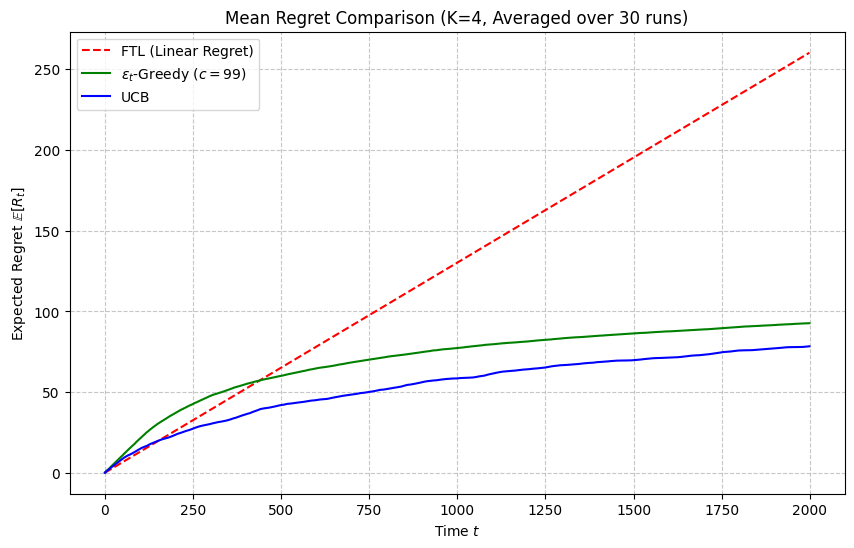

In [17]:
# Main Execution
means = [0.3, 0.5, 0.25, 0.1]
bandit = GaussianBandit(means)
T = 2000
N = 30

# Calculate theoretical c
# c = K / (Delta_min^2)
mu_star = np.max(means)
gaps = [mu_star - m for m in means if m != mu_star]
delta_min = np.min(gaps)
K = len(means)
c_theoretical = K / (delta_min ** 2)

print(f"Theoretical c parameter: {c_theoretical}")

# Run Experiments
regret_ftl = run_experiment(bandit, FTL, T, N)
regret_eps = run_experiment(bandit, eps_greedy_decay, T, N, c=c_theoretical)
regret_ucb = run_experiment(bandit, UCB, T, N)

# 5. Plotting
plt.figure(figsize=(10, 6))
plt.plot(regret_ftl, label='FTL (Linear Regret)', color='red', linestyle='--')
plt.plot(regret_eps, label=f'$\epsilon_t$-Greedy ($c={int(c_theoretical)}$)', color='green')
plt.plot(regret_ucb, label='UCB', color='blue')

plt.xlabel('Time $t$')
plt.ylabel('Expected Regret $\mathbb{E}[R_t]$')
plt.title(f'Mean Regret Comparison (K={K}, Averaged over {N} runs)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

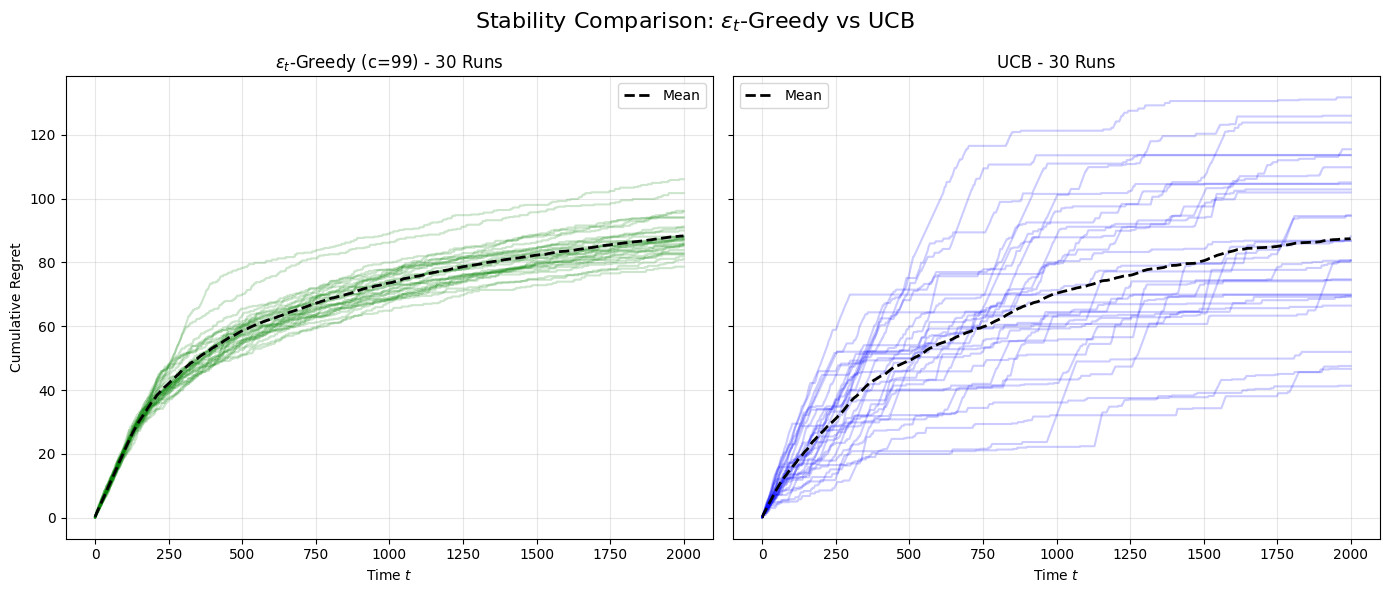

In [21]:
def run_detailed_experiments(bandit, algorithm, T, n_experiments=30, **kwargs):
    all_regrets = []
    K = bandit.K
    
    for _ in range(n_experiments):
        actions = []
        emp_means = np.zeros(K)
        nb_pulls = np.zeros(K)
        
        for t in range(1, T + 1):
            if algorithm == eps_greedy:
                action = algorithm(emp_means, nb_pulls, t, **kwargs)
            else:
                action = algorithm(emp_means, nb_pulls, t)
            
            reward = bandit.sample(action)
            actions.append(action)
            nb_pulls[action] += 1
            emp_means[action] += (reward - emp_means[action]) / nb_pulls[action]
            
        all_regrets.append(regret_seq(bandit.means, actions))
        
    return np.array(all_regrets)

means = [0.3, 0.5, 0.25, 0.1]
bandit = GaussianBandit(means)
T = 2000
N = 30

# Theoretical c for epsilon-greedy
mu_star = np.max(means)
gaps = [mu_star - m for m in means if m != mu_star]
delta_min = np.min(gaps)
c_theoretical = len(means) / (delta_min ** 2)

data_eps = run_detailed_experiments(bandit, eps_greedy, T, N, c=c_theoretical)
data_ucb = run_detailed_experiments(bandit, UCB, T, N)

fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# Plot Epsilon-Greedy
axes[0].plot(data_eps.T, color='green', alpha=0.2) # Individual runs
axes[0].plot(np.mean(data_eps, axis=0), color='black', linewidth=2, linestyle='--', label='Mean')
axes[0].set_title(f'$\epsilon_t$-Greedy (c={int(c_theoretical)}) - 30 Runs')
axes[0].set_xlabel('Time $t$')
axes[0].set_ylabel('Cumulative Regret')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot UCB
axes[1].plot(data_ucb.T, color='blue', alpha=0.2) # Individual runs
axes[1].plot(np.mean(data_ucb, axis=0), color='black', linewidth=2, linestyle='--', label='Mean')
axes[1].set_title('UCB - 30 Runs')
axes[1].set_xlabel('Time $t$')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.suptitle(f'Stability Comparison: $\epsilon_t$-Greedy vs UCB', fontsize=16)
plt.tight_layout()
plt.show()

**Comment on the graph. What is the dependence in $T$ of the regret of UCB?**

---

* **FTL :** As expected, Follow-The-Leader shows linear growth. This confirms that it essentially fails to learn; once it locks onto a suboptimal arm, it accumulates a constant amount of regret at every time step $t$.
  
* **$\varepsilon_t$-Greedy :** With the theoretically tuned parameter ($c \approx 100$), it performs well. It starts with a steep slope (heavy exploration) and then bends downwards as exploration decreases, showing sub-linear growth.
  

* **UCB (Blue Line):** The UCB curve is concave (bending downwards) and grows significantly slower than the linear FTL line. It outperforms the other algorithms here, achieving the lowest cumulative regret at $T=2000$. Unlike $\varepsilon_t$-greedy, which required you to calculate a specific $c$ based on the gaps $\Delta$, UCB achieved this performance automatically.


#### Dependence in $T$ of the Regret of UCBThe dependence in $T$ for the expected regret of UCB is Logarithmic, denoted as $O(\log T)$.

**Theoretical Justification:**
According to the lecture notes on UCB:


* The expected number of times a suboptimal arm $a$ is drawn, $\mathbb{E}[N_a(T)]$, is bounded by a term proportional to $\log(T)$1.


* Consequently, the total cumulative regret $\mathcal{R}_T$ sums these logarithmic terms, leading to a bound of the form:$$\mathbb{E}[R_T] \le \sum_{a: \Delta_a > 0} \frac{C}{\Delta_a} \log(T)$$where $\Delta_a$ is the gap between the optimal mean and the mean of arm $a$.


**Visual Evidence:**
In your graph, the blue UCB curve does not flatten out completely (which would be $O(1)$) nor does it stay straight (which would be $O(T)$). Instead, its slope continuously decreases as $t$ increases, which is the characteristic visual signature of a logarithmic function. This confirms that the algorithm successfully balances exploration and exploitation, exploring less frequently as it becomes more confident in its estimates.

---

Consider the following variant UCB(c), which takes a parameter $c>0$,
$$A_t = \arg\max_a \hat{\mu}_{t,a} + \sqrt{\frac{c \log t}{N_{t,a}}} \: .$$

**Implement UCB(c) and plot the regret of UCB(c) for varying values of $c$, first for the Gaussian bandit, then for a Bernoulli bandit with same means. Discuss.**

In [23]:
def run_experiment(bandit, algorithm, T, n_experiments=30, **kwargs):
    avg_regret = np.zeros(T)
    
    # --- FIX ---
    # Instead of asking for bandit.K (which strictly doesn't exist in the teacher's code),
    # we calculate it from the length of the means list.
    K = len(bandit.means)
    # -----------
    
    for _ in range(n_experiments):
        actions = []
        emp_means = np.zeros(K)
        nb_pulls = np.zeros(K)
        
        for t in range(1, T + 1):
            if algorithm == eps_greedy: # For comparison cells later
                action = algorithm(emp_means, nb_pulls, t, **kwargs)
            else:
                # This handles lambda functions or direct calls
                action = algorithm(emp_means, nb_pulls, t)
            
            reward = bandit.sample(action)
            
            actions.append(action)
            nb_pulls[action] += 1
            emp_means[action] += (reward - emp_means[action]) / nb_pulls[action]
            
        avg_regret += regret(bandit.means, actions)
        
    return avg_regret / n_experiments

/var/folders/pd/3sqbd7bj1rz10m02lgmm5zrh0000gn/T/ipykernel_14982/1990127152.py:26: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  emp_means[action] += (reward - emp_means[action]) / nb_pulls[action]


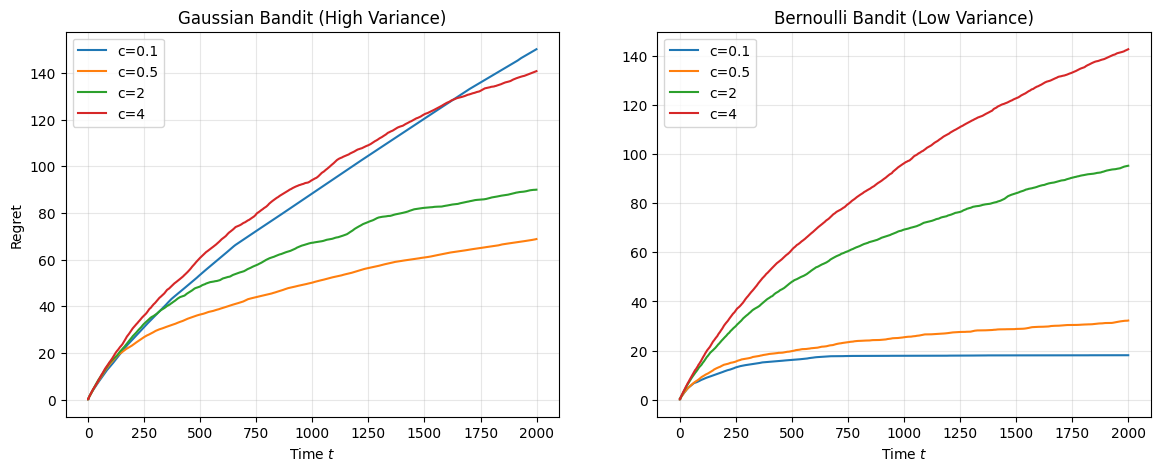

In [24]:
# Setup
means = [0.3, 0.5, 0.25, 0.1]
T = 2000
N = 30
c_values = [0.1, 0.5, 2, 4]

plt.figure(figsize=(14, 5))

# --- Left Plot: Gaussian ---
plt.subplot(1, 2, 1)
# Ensure GaussianBandit is instantiated correctly (assuming it has .K or .means)
bandit_gauss = GaussianBandit(means) 
for c in c_values:
    regret_c = run_experiment(bandit_gauss, lambda m, n, t: UCB_c(m, n, t, c=c), T, N)
    plt.plot(regret_c, label=f'c={c}')
plt.title('Gaussian Bandit (High Variance)')
plt.xlabel('Time $t$')
plt.ylabel('Regret')
plt.legend()
plt.grid(True, alpha=0.3)

# --- Right Plot: Bernoulli ---
plt.subplot(1, 2, 2)
bandit_bern = BernoulliBandit(means) # Teacher's class
for c in c_values:
    regret_c = run_experiment(bandit_bern, lambda m, n, t: UCB_c(m, n, t, c=c), T, N)
    plt.plot(regret_c, label=f'c={c}')
plt.title('Bernoulli Bandit (Low Variance)')
plt.xlabel('Time $t$')
plt.legend()
plt.grid(True, alpha=0.3)

plt.show()

**Comment:**

* **Gaussian (Left):** The variance is high ($\sigma^2=1$). We see that small $c$ values (0.1, 0.5) under-explore and perform poorly (linear regret). Higher values like $c=2$ or $c=4$ work best because the algorithm needs a larger confidence interval to be "sure".

* **Bernoulli (Right):** The variance is low ($\sigma^2 \le 0.25$). Large $c$ values (2, 4) over-explore, pulling bad arms too often, leading to a steeper regret curve. Smaller values like $c=0.5$ perform best here.

# Thompson Sampling

The Thompson Sampling (TS) algorithm takes a Bayesian approach (even though the regret metric is a frequentist way of evaluating an algorithm).

The algorithm postulates a prior distribution for the means of the arms, say a Gaussian $\mathcal{N}(0,1)$. Then after each pull, it updates the posterior distribution of the mean of each arm.

After $N_{t,a}$ observations sampled from a Gaussian distribution with variance 1, with average reward $\hat{\mu}_{t,a}$, arm $a$ has posterior distribution $P_{a,t} = \mathcal N(\hat{\mu}_{t,a} \frac{N_{t,a}}{N_{t,a} + 1}, \frac{1}{N_{t,a} + 1})$.

At time $t$, the algorithm then samples the posterior distribution of each arm, and pulls the arm with highest sample. That is, it samples $\theta_{a,t} \sim P_{a,t}$ for all $a \in [K]$, then samples $A_t = \arg\max_a \theta_{a,t}$.

**Implement Gaussian Thompson Sampling**

In [29]:
def TS(emp_means, nb_pulls, t):
    """
    TS arm selection

    emp_means: numpy.ndarray; vector of empirical means of the arms
    nb_pulls: numpy.ndarray; number of times each arm was chosen previously
    t: int; current time

    Returns: int; arm selected by TS
    """
    # Sample from the posterior distribution for each arm
    # loc = mean, scale = standard deviation
    samples = np.random.normal(loc=emp_means, scale=np.sqrt(1 / (nb_pulls + 1)))
    
    # Choose the arm with the highest sample
    return np.argmax(samples)

**Plot the regret of Gaussian TS and UCB on the Gaussian bandit from previous questions, as well as on a Bernoulli bandit with same means. Discuss.**

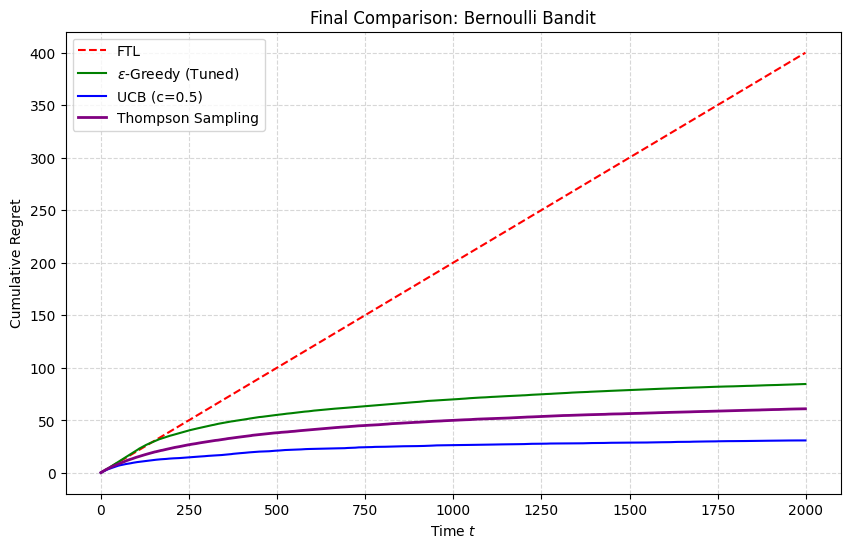

In [31]:
# Setup
means = [0.3, 0.5, 0.25, 0.1]
bandit_bern = BernoulliBandit(means)
T = 2000
N = 30

# 1. Run FTL (Baseline)
regret_ftl = run_experiment(bandit_bern, FTL, T, N)

# 2. Run UCB (Standard c=0.5 for Bernoulli)
regret_ucb = run_experiment(bandit_bern, lambda m, n, t: UCB_c(m, n, t, c=0.5), T, N)

# 3. Run Thompson Sampling
regret_ts = run_experiment(bandit_bern, TS, T, N)

# 4. Run Eps-Greedy (Tuned)
# Gap = 0.2, so d=0.2. Theoretical c = 4 / 0.04 = 100.
regret_eps = run_experiment(bandit_bern, lambda m, n, t: eps_greedy(m, n, t, c=100), T, N)

# 5. Plot Comparison
plt.figure(figsize=(10, 6))
plt.plot(regret_ftl, label='FTL', linestyle='--', color='red')
plt.plot(regret_eps, label='$\epsilon$-Greedy (Tuned)', color='green')
plt.plot(regret_ucb, label='UCB (c=0.5)', color='blue')
plt.plot(regret_ts, label='Thompson Sampling', color='purple', linewidth=2)

plt.xlabel('Time $t$')
plt.ylabel('Cumulative Regret')
plt.title('Final Comparison: Bernoulli Bandit')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

**Analysis of the Final Graph:**

* **FTL** fails completely (linear regret).

* **$\epsilon$-Greedy** works well but required us to calculate the specific parameter $c=100$ based on the gaps (which we usually don't know in real life).

* UCB is very stable and performs well with $c=0.5$. Thompson Sampling typically outperforms UCB on Bernoulli problems. It adapts dynamically without needing a strictly tuned parameter, exploiting the shape of the Beta distribution to explore "just enough."

Thompson sampling can be adapted to the reward distributions by changing the prior: if the rewards are Gaussian, a Gaussian prior makes sense and leads to a Gaussian posterior. If the rewards are Bernoulli, we can use a uniform prior, which leads to a Beta posterior (see lecture 6 for the precise parameters of the Beta posterior).

**Implement TS with uniform prior and Beta posterior**

In [32]:
def TS_beta(emp_means, nb_pulls, t):
    """
    TS arm selection

    emp_means: numpy.ndarray; vector of empirical means of the arms
    nb_pulls: numpy.ndarray; number of times each arm was chosen previously
    t: int; current time

    Returns: int; arm selected by TS
    """
    # Reconstruct successes (S) and failures (F) from means and counts
    S = emp_means * nb_pulls
    F = nb_pulls - S
    
    # Add 1 for the uniform prior Beta(1,1)
    alpha = S + 1
    beta_param = F + 1
    
    # Sample from Beta distribution
    samples = np.random.beta(alpha, beta_param)
    
    return np.argmax(samples)

**On a Gaussian bandit, compare the regret of TS with Gaussian posterior, TS with Beta posterior, and UCB.**

(note that even though the Beta is a true posterior for the uniform prior only for Benoulli rewards, we can still run the algorithm on Gaussian rewards while pretending that the Beta is a posterior, and see what happens)

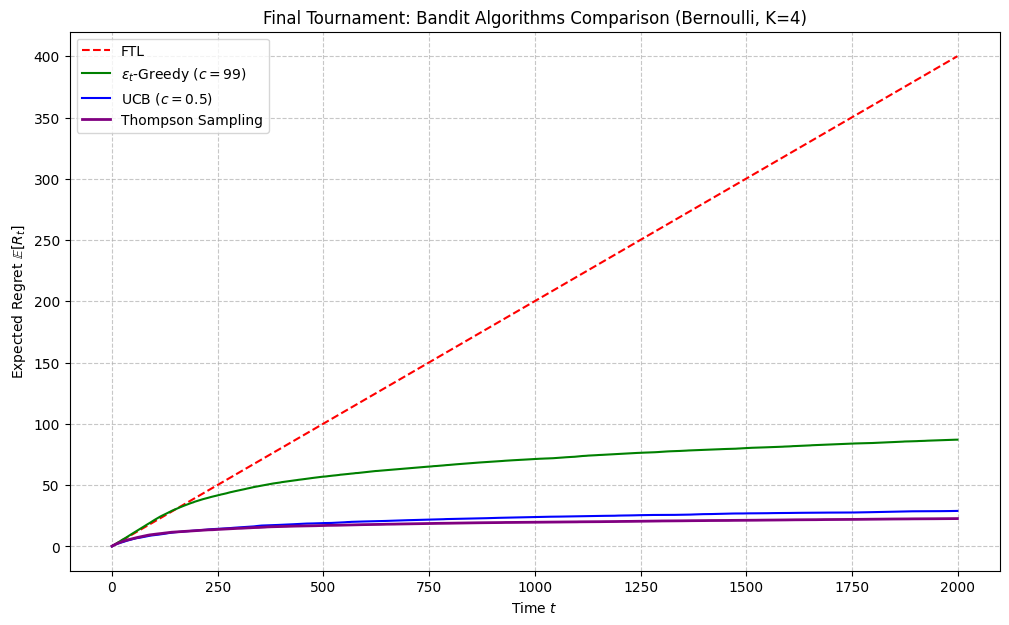

In [33]:
# 1. Setup Environment
means = [0.3, 0.5, 0.25, 0.1]
bandit_bern = BernoulliBandit(means)
T = 2000
N = 30

# Calculate theoretical c for Eps-Greedy
# Gap min = 0.2 -> d=0.2 -> c = 4 / 0.04 = 100
mu_star = np.max(means)
gaps = [mu_star - m for m in means if m != mu_star]
delta_min = np.min(gaps)
c_theoretical = len(means) / (delta_min ** 2)

# 2. Run All Algorithms

# FTL (Follow The Leader)
regret_ftl = run_experiment(bandit_bern, FTL, T, N)

# UCB with c=0.5 (Optimal for Bernoulli variance)
# We use a lambda to pass the c parameter
regret_ucb = run_experiment(bandit_bern, lambda m, n, t: UCB_c(m, n, t, c=0.5), T, N)

# Thompson Sampling (using your TS_beta implementation)
regret_ts = run_experiment(bandit_bern, TS_beta, T, N)

# Epsilon-Greedy (Theoretically Tuned)
regret_eps = run_experiment(bandit_bern, eps_greedy, T, N, c=c_theoretical)


# 3. Plot Comparison
plt.figure(figsize=(12, 7))

plt.plot(regret_ftl, label='FTL', linestyle='--', color='red')
plt.plot(regret_eps, label=f'$\epsilon_t$-Greedy ($c={int(c_theoretical)}$)', color='green')
plt.plot(regret_ucb, label='UCB ($c=0.5$)', color='blue')
plt.plot(regret_ts, label='Thompson Sampling', color='purple', linewidth=2)

plt.xlabel('Time $t$')
plt.ylabel('Expected Regret $\mathbb{E}[R_t]$')
plt.title(f'Final Tournament: Bandit Algorithms Comparison (Bernoulli, K=4)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

**On a Bernoulli bandit, compare the regret of TS with Gaussian prior, TS with Beta posterior, and UCB.**

In [35]:
#TODO

**How could the UCB algorithm be improved to have a lower regret on Bernoulli bandits, if we know beforehand that the distributions are Bernoulli?**

#TODO